## Libraries

In [1]:
import os
from collections import Counter
import pickle

import numpy as np

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, optimizers, callbacks
from tensorflow.keras.datasets import mnist

from matplotlib import pyplot as plt

In [2]:
# load data
(xtrain_, ytrain), (xtest, ytest) = mnist.load_data()

# preprocessing: rescaling, reshaping
def preprocess_images(x):
    return x.astype('float32') / 255.

xtrain = preprocess_images(xtrain_)

# Split some data for training/validation/testing
Xtrain_, Xrest_, Ytrain, Yrest_ = train_test_split(xtrain, ytrain, train_size=10000)
Xval_, Xrest_, Yval, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=1000)
Xtest_, Xrest_, Ytest, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=10000)


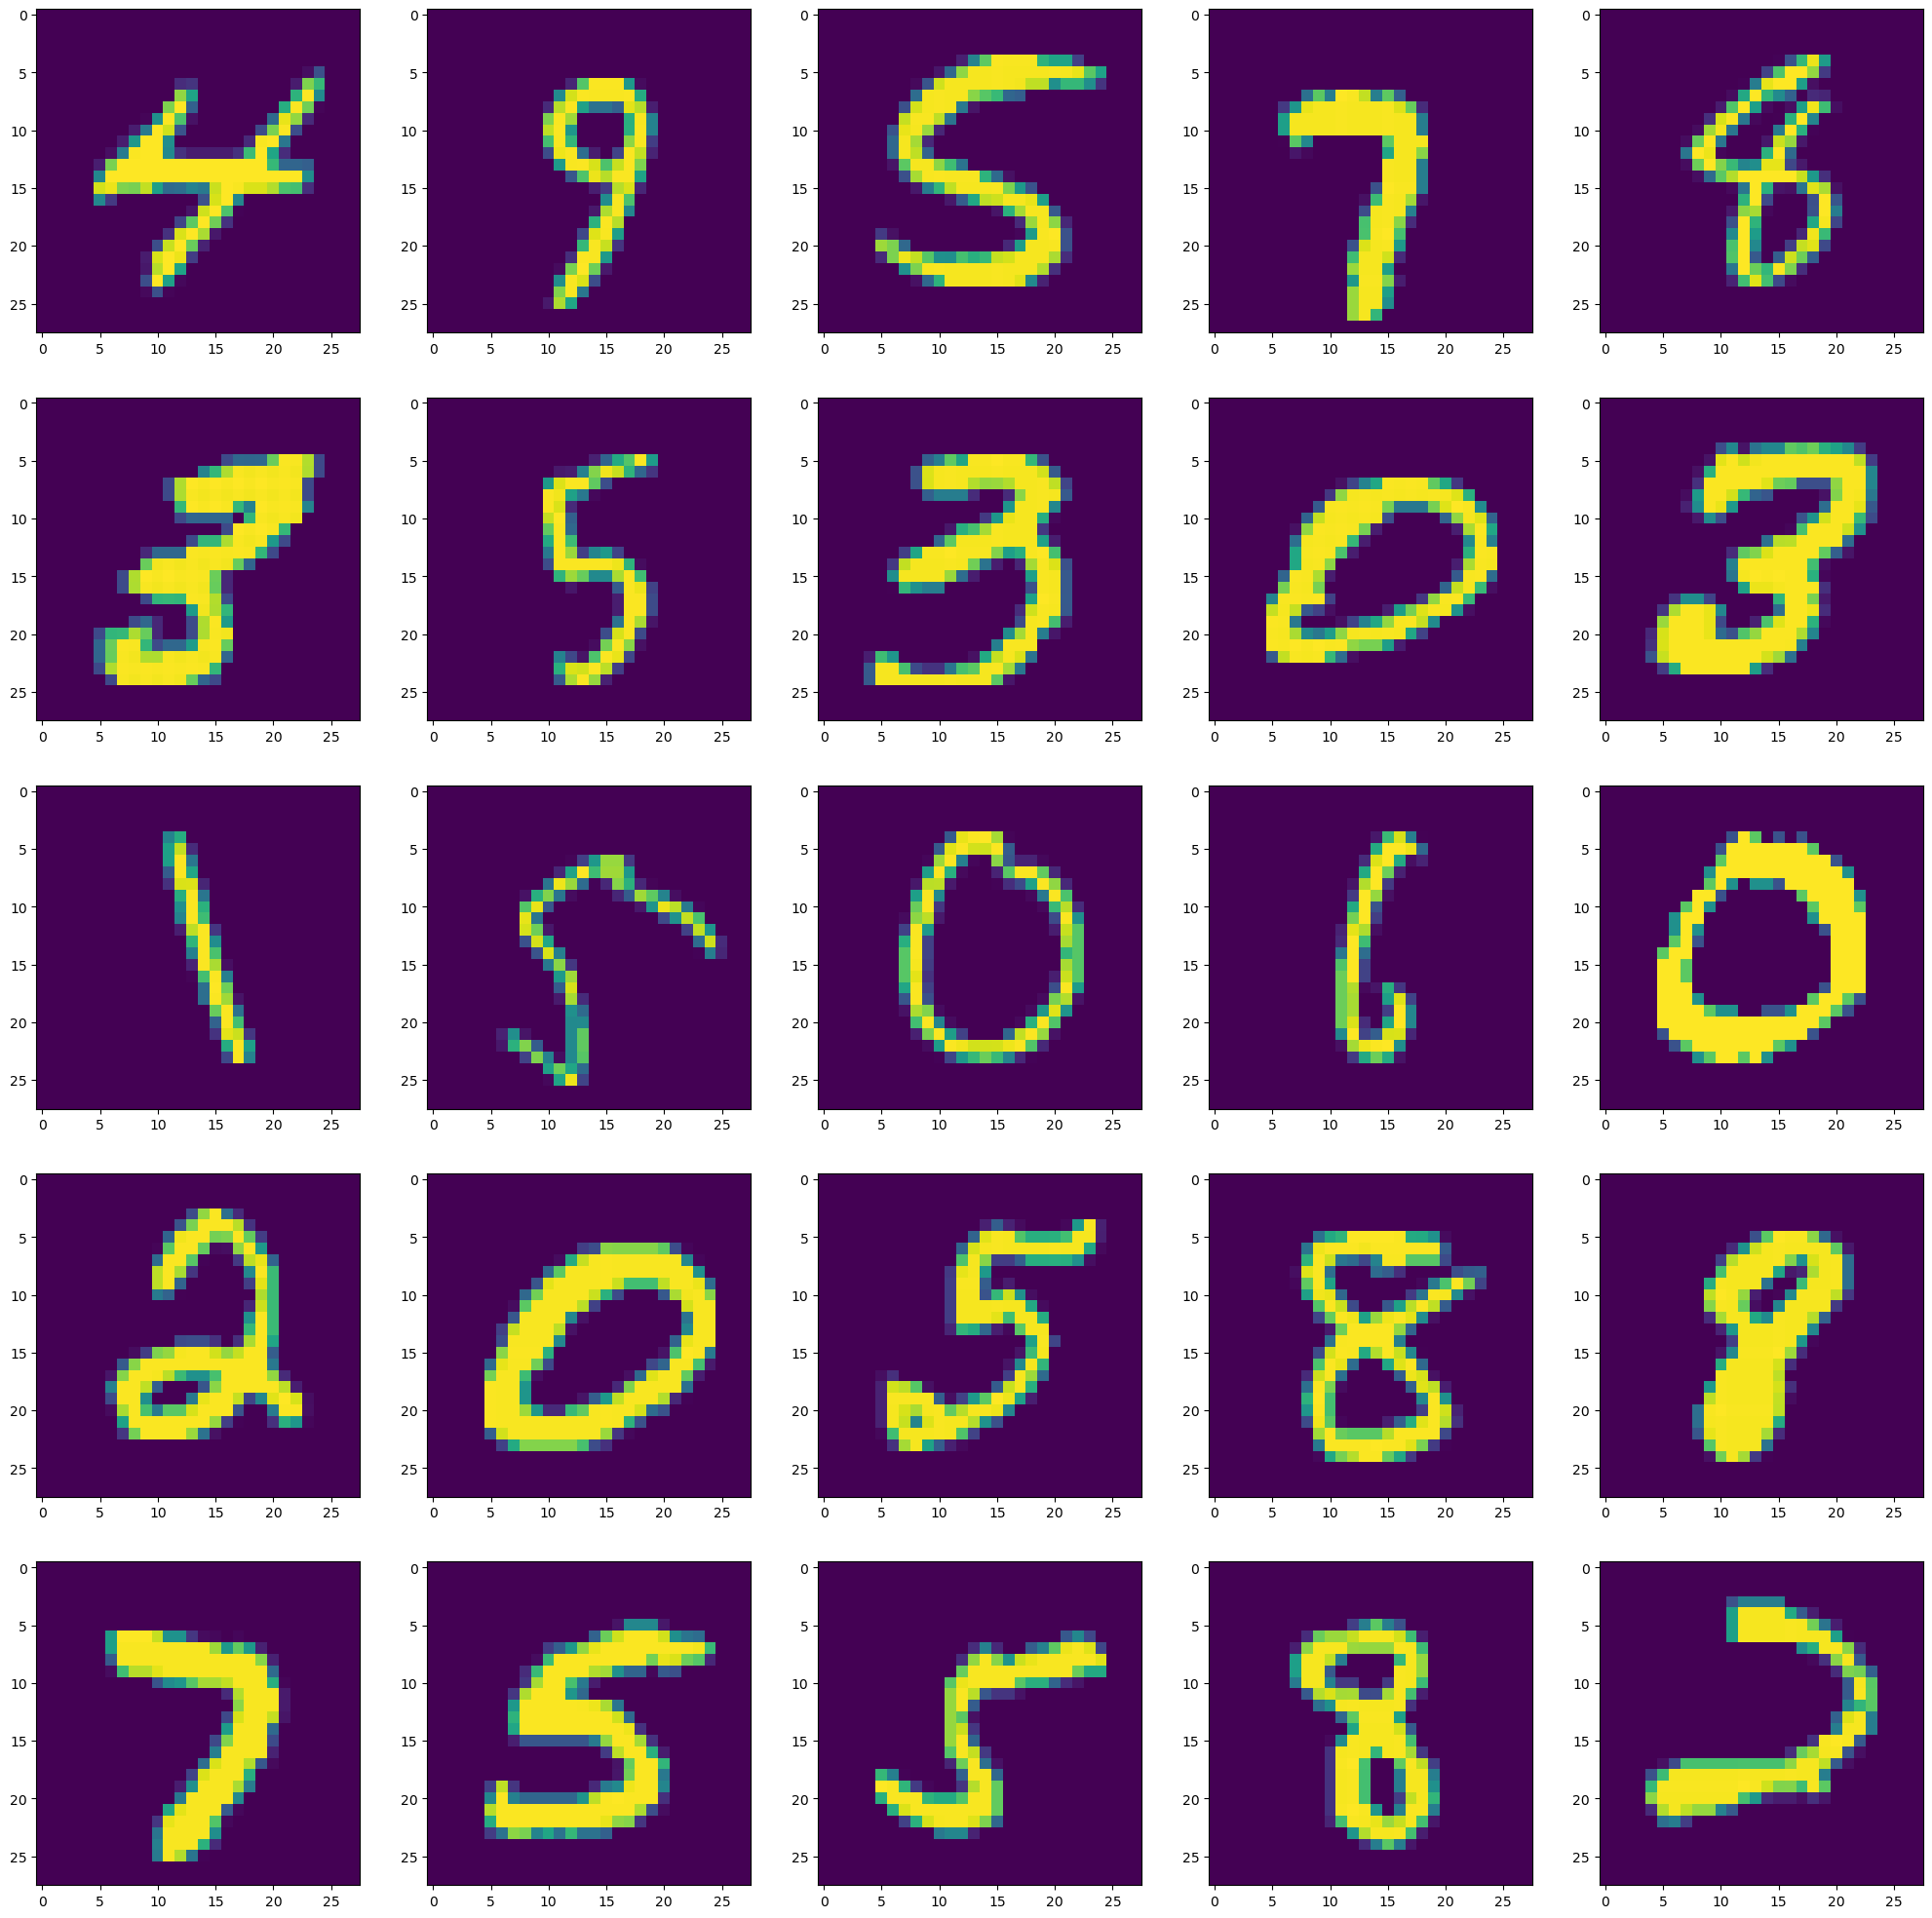

In [3]:
# plot some samples

idxs = np.random.choice(len(Xtrain_), 25, replace=False)
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
for idx, ax in zip(idxs, axs.flatten()):
    ax.imshow(Xtrain_[idx])

In [4]:
# sklearn needs the format n_samples x n_feature
Xtrain = Xtrain_.reshape((Xtrain_.shape[0], -1))
Xtest = Xtest_.reshape((Xtest_.shape[0], -1))
print(Xtrain.shape)
print(Counter(Ytrain))
                         

(10000, 784)
Counter({1: 1074, 0: 1041, 8: 1018, 9: 1015, 2: 1011, 7: 1007, 4: 997, 3: 984, 6: 971, 5: 882})


In [5]:
# train a classifier

LR = LogisticRegression(max_iter=1000)
LR.fit(Xtrain, Ytrain)

LogisticRegression(max_iter=1000)

In [6]:
# evaluate trained classifier on test set
Ypred = LR.predict(Xtest)
print(classification_report(Ytest, Ypred))
print(confusion_matrix(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       961
           1       0.94      0.96      0.95      1135
           2       0.87      0.88      0.87       987
           3       0.89      0.85      0.87      1044
           4       0.89      0.91      0.90      1014
           5       0.85      0.83      0.84       882
           6       0.92      0.93      0.93       961
           7       0.91      0.91      0.91      1053
           8       0.87      0.85      0.86       939
           9       0.88      0.88      0.88      1024

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[[ 911    1    3    3    3   15   13    3    8    1]
 [   0 1086   15    7    1    4    4    3   14    1]
 [   7   14  864   19   20    7   16   11   19   10]
 [   3    7   34  891    1   44    4   21   28   11]
 [   0    4   14    2  927   

In [7]:
# try a better model
RF = RandomForestClassifier()
RF.fit(Xtrain, Ytrain)

RandomForestClassifier()

In [8]:
# evaluate trained classifier on test set
Ypred2 = RF.predict(Xtest)
print(classification_report(Ytest, Ypred2))
print(confusion_matrix(Ytest, Ypred2))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       961
           1       0.97      0.97      0.97      1135
           2       0.94      0.95      0.95       987
           3       0.95      0.93      0.94      1044
           4       0.96      0.95      0.96      1014
           5       0.94      0.94      0.94       882
           6       0.96      0.97      0.97       961
           7       0.96      0.95      0.95      1053
           8       0.92      0.93      0.93       939
           9       0.92      0.94      0.93      1024

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[ 934    0    2    1    2    5    5    0   12    0]
 [   0 1103   13    5    2    1    3    3    3    2]
 [   4    2  939    8    6    1    6    7   10    4]
 [   2    5   12  972    0   16    3   13   17    4]
 [   1    1    5    0  968   

In [9]:
# Hyperparameter tuning
param_grid = {
    "n_estimators" : [200, 500],
    "max_depth" : [None, 10, 50],
    "max_features" : ["sqrt", "log2", .1]
}

RF_tuned = GridSearchCV(RandomForestClassifier(), 
                        param_grid=param_grid,
                        cv=4,
                        n_jobs=-1,
                        verbose=4)
RF_tuned.fit(Xtrain, Ytrain)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 50],
                         'max_features': ['sqrt', 'log2', 0.1],
                         'n_estimators': [200, 500]},
             verbose=4)

In [10]:
# display crossvalidation results
cv_results = pd.DataFrame(RF_tuned.cv_results_)
disp_cols = ["param_n_estimators", "param_max_depth", "param_max_features", "mean_fit_time", "mean_test_score"]
mapper = dict(zip(disp_cols[:3], ['n_estimators', 'max_depth', 'max_features']))
renamed_df = cv_results[disp_cols].copy()
renamed_df.rename(columns=mapper, inplace=True)
print(renamed_df.sort_values('mean_test_score', ascending=False))


   n_estimators max_depth max_features  mean_fit_time  mean_test_score
1           500      None         sqrt      15.711785           0.9486
5           500      None          0.1      41.967421           0.9482
13          500        50         sqrt      15.681445           0.9482
17          500        50          0.1      34.600376           0.9481
15          500        50         log2       6.842124           0.9473
0           200      None         sqrt       6.005445           0.9472
3           500      None         log2       6.604334           0.9471
14          200        50         log2       2.781757           0.9461
4           200      None          0.1      15.149375           0.9460
12          200        50         sqrt       6.299762           0.9459
16          200        50          0.1      16.149110           0.9456
2           200      None         log2       2.634435           0.9448
7           500        10         sqrt      13.005077           0.9372
11    

In [11]:
# evaluate trained classifier on test set
print(RF_tuned.best_params_)
Ypred3 = RF_tuned.predict(Xtest)
print(classification_report(Ytest, Ypred3))
print(confusion_matrix(Ytest, Ypred3))

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       961
           1       0.97      0.97      0.97      1135
           2       0.94      0.95      0.95       987
           3       0.96      0.93      0.94      1044
           4       0.96      0.96      0.96      1014
           5       0.95      0.94      0.95       882
           6       0.96      0.97      0.97       961
           7       0.96      0.94      0.95      1053
           8       0.93      0.94      0.93       939
           9       0.93      0.94      0.93      1024

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[ 935    0    1    1    2    3    7    0   11    1]
 [   0 1104   14    4    1    1    4    2    3    2]
 [   6    2  938    9    5    0    9    6   10    2]
 [   2    5   16 

In [12]:
# Convolutional Neural Network in tensorflow using keras API

def mnist_clf(input_shape=(28, 28, 1), n_classes=10):
    inx = Input(input_shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(inx)
    x = layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(n_classes)(x)
    return Model(inx, x)

clf_mnist = mnist_clf()
clf_mnist.summary()

# select loss function and optimizer
loss = losses.CategoricalCrossentropy(from_logits=True)
opt = optimizers.Nadam(learning_rate=1e-2)
clf_mnist.compile(loss=loss, optimizer=opt, metrics=["accuracy"])

# preprocess data: scaling of images, one-hot encoding of labels
def preprocess_tf(x, y):
    return x, tf.one_hot(y, depth=10, axis=-1)

trainset = tf.data.Dataset.from_tensor_slices((Xtrain_, Ytrain)).shuffle(Xtrain_.shape[0]).batch(256).map(preprocess_tf)
valset = tf.data.Dataset.from_tensor_slices((Xval_, Yval)).batch(1000).map(preprocess_tf)

# callback for saving model
MdlCpt = callbacks.ModelCheckpoint("convert_mnist", save_best_only=True)
    

Metal device set to: Apple M1 Pro


2022-10-31 22:32:16.130935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 22:32:16.131492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 10)                1290  

In [13]:
hist = clf_mnist.fit(trainset, 
                     validation_data=valset,
                     epochs=100,
                     callbacks=[MdlCpt])

Epoch 1/100


2022-10-31 22:32:16.486336: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-31 22:32:16.980032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 0.8993 - accuracy: 0.7244

2022-10-31 22:32:18.717334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: .convert_mnist/assets


INFO:tensorflow:Assets written to: .convert_mnist/assets


40/40 [==============================] - 3s 52ms/step - loss: 0.8993 - accuracy: 0.7244 - val_loss: 0.7694 - val_accuracy: 0.7830
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9500

INFO:tensorflow:Assets written to: .convert_mnist/assets


INFO:tensorflow:Assets written to: .convert_mnist/assets


40/40 [==============================] - 2s 44ms/step - loss: 0.1686 - accuracy: 0.9500 - val_loss: 0.5520 - val_accuracy: 0.8790
Epoch 3/100
39/40 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9705

INFO:tensorflow:Assets written to: .convert_mnist/assets


INFO:tensorflow:Assets written to: .convert_mnist/assets


40/40 [==============================] - 2s 43ms/step - loss: 0.0970 - accuracy: 0.9705 - val_loss: 0.1706 - val_accuracy: 0.9540
Epoch 4/100
40/40 [==============================] - 1s 24ms/step - loss: 0.0443 - accuracy: 0.9854 - val_loss: 0.7275 - val_accuracy: 0.8800
Epoch 5/100
40/40 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9730

INFO:tensorflow:Assets written to: .convert_mnist/assets


INFO:tensorflow:Assets written to: .convert_mnist/assets


40/40 [==============================] - 2s 44ms/step - loss: 0.0897 - accuracy: 0.9730 - val_loss: 0.1387 - val_accuracy: 0.9700
Epoch 6/100
40/40 [==============================] - 1s 26ms/step - loss: 0.0190 - accuracy: 0.9949 - val_loss: 0.1458 - val_accuracy: 0.9750
Epoch 7/100
40/40 [==============================] - 1s 25ms/step - loss: 0.1062 - accuracy: 0.9733 - val_loss: 0.1529 - val_accuracy: 0.9600
Epoch 8/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0398 - accuracy: 0.9865 - val_loss: 0.1426 - val_accuracy: 0.9690
Epoch 9/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.1617 - val_accuracy: 0.9710
Epoch 10/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.2019 - val_accuracy: 0.9710
Epoch 11/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.1819 - val_accuracy: 0.9750
Epoch 12/100
40/

Metrics on test set
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       961
           1       0.99      0.97      0.98      1135
           2       0.96      0.97      0.97       987
           3       0.97      0.96      0.96      1044
           4       0.96      0.97      0.97      1014
           5       0.95      0.96      0.96       882
           6       0.98      0.97      0.98       961
           7       0.96      0.97      0.96      1053
           8       0.94      0.94      0.94       939
           9       0.96      0.96      0.96      1024

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 943    1    2    1    3    1    4    0    5    1]
 [   0 1101   12    1    5    1    1    2    8    4]
 [   2    1  957    3    2    0    3    9    8    2]
 [   2    0    9  998    0   14    0    5   13    3]
 [   2   

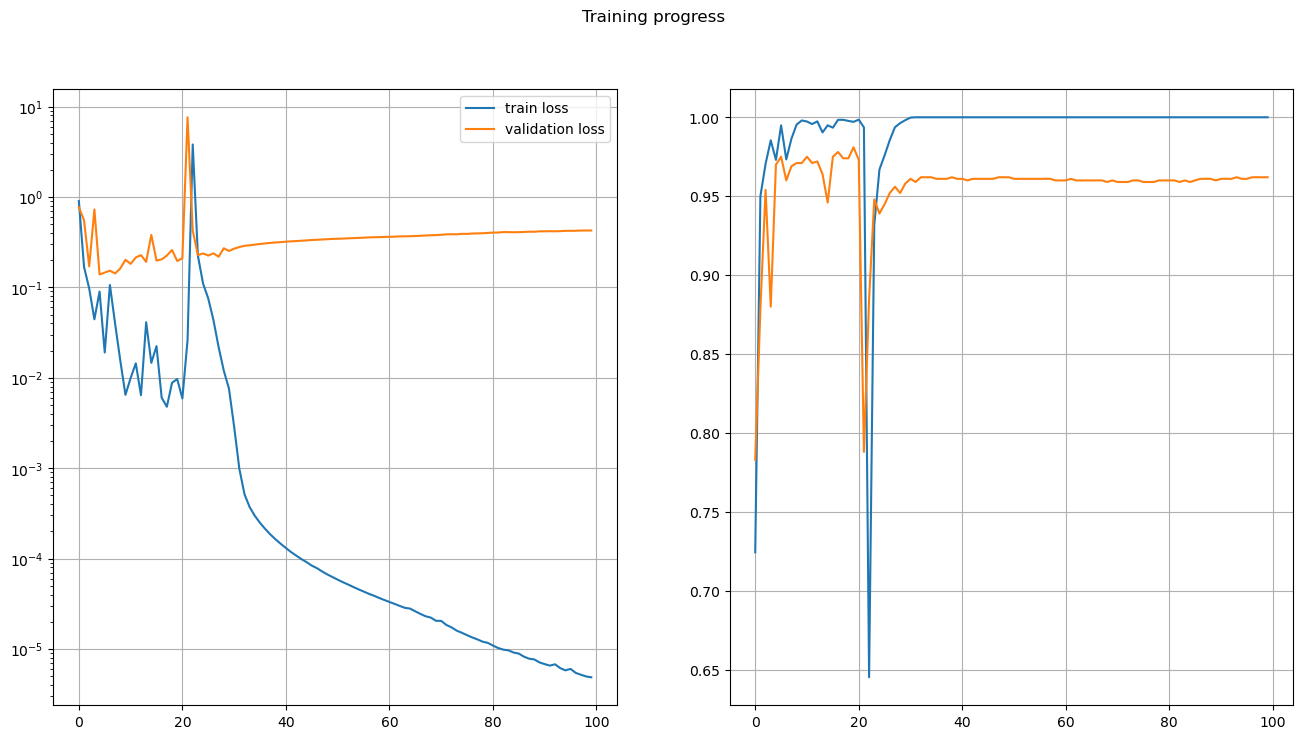

In [14]:
# plot training metrics

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].semilogy(hist.history["loss"], label="train loss")
ax[0].semilogy(hist.history["val_loss"], label="validation loss")
ax[1].plot(hist.history["accuracy"], label="train accuracy");
ax[1].plot(hist.history['val_accuracy'], label='validation accuracy');
ax[0].legend();
ax[1].legend;
ax[1].grid()
ax[0].grid()
fig.suptitle('Training progress')

print('Metrics on test set')
# display results with trained classifier (100 epochs)
Ypred4 = tf.argmax(clf_mnist(Xtest_), axis=-1)
print(classification_report(Ytest, Ypred4))
print(confusion_matrix(Ytest, Ypred4))

In [15]:
clf_mnist.evaluate(Xtest_, tf.one_hot(Ytest, depth=10), verbose=1)

313/313 [==============================] - 3s 9ms/step - loss: 0.2706 - accuracy: 0.9658


[0.27064719796180725, 0.9658000469207764]

In [16]:
# load best model from checkpoint
print('Best model found in epoch ', np.argmin(hist.history['val_loss'])+1)
clf2 = tf.keras.models.load_model('convert_mnist')
Ypred5 = tf.argmax(clf2(Xtest_), axis=-1)
print(classification_report(Ytest, Ypred5))
print(confusion_matrix(Ytest, Ypred5))

Best model found in epoch  5
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       961
           1       0.95      0.99      0.97      1135
           2       0.98      0.96      0.97       987
           3       0.95      0.98      0.96      1044
           4       0.96      0.98      0.97      1014
           5       0.99      0.97      0.98       882
           6       0.97      0.99      0.98       961
           7       0.98      0.95      0.97      1053
           8       0.98      0.91      0.95       939
           9       0.95      0.97      0.96      1024

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 941    1    2    1    2    2    9    0    3    0]
 [   0 1123    4    4    1    0    0    1    1    1]
 [   7   10  945    7    7    0    2    6    2    1]
 [   1    3    5 1022    0    3    0    5    1    4]
